In [1]:
import cv2
import scipy
import numpy as np
import pyxis as px
import PIL.Image as Image
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
from scipy import ndimage
from collections import defaultdict
from scipy.misc import imresize

## List all the images with car and truck labels
We will create a list dictanry with all the trucks and car bounding boxes. 
We restric the list to only have cars and truck abose some pixel size. This threshold was selecte after some trial and error.

In [2]:
cars_images = defaultdict(list)

In [3]:
with open('object-dataset/labels.csv', 'r') as fd:
    for line in fd:
        line= line.rstrip()
        splits = line.split(' ')
        if splits[-1]=='"car"' or  splits[-1]=='"truck"' :
            filename = 'object-dataset/'+splits[0]
            if np.abs(int(splits[1]) - int(splits[3])) >50:
                if np.abs(int(splits[2]) - int(splits[4])) >50:
                    if len([item for item in cars_images[filename] if np.sum(item)>0]) < 10:
                        cars_images[filename].append([int(x) for x in splits[1:5]])


In [4]:
with open('DATA/labels.csv', 'r') as fd:
    # Skip header
    next(fd)
    for line in fd:
        line= line.rstrip()
        splits = line.split(',')
        filename = 'DATA/'+splits[4]
        if np.abs(int(splits[0]) - int(splits[2])) >100:
            if np.abs(int(splits[1]) - int(splits[3])) >100:
                if len([item for item in cars_images[filename] if np.sum(item)>0]) <10:
                    cars_images[filename].append([int(x) for x in splits[0:4]])


# Visulize a sample, by printing the coordinates and plotting the image

In [5]:
cars_images['object-dataset/1478898633665600061.jpg']

[[84, 592, 176, 668],
 [176, 592, 274, 674],
 [282, 594, 386, 656],
 [1082, 570, 1160, 628],
 [1086, 570, 1160, 632],
 [1182, 558, 1276, 648],
 [1392, 558, 1734, 760],
 [1438, 566, 1712, 762]]

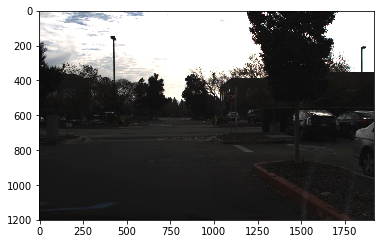

In [6]:
plt.imshow(Image.open('object-dataset/1478898633665600061.jpg'))

## Compute a heat mask

We compute a heat mask for the car.
The center of the bouding box has highest number and it gradually goes down as we get closer to the bouding box bordes.

In [7]:
def compute_mask(filename, plot = False):
    img = np.array(Image.open(filename))
    all_m = np.zeros(img.shape[0:2],dtype=np.uint8)
    j=0
    for car_cordinates in cars_images[filename]:
        mask = np.zeros(img.shape[0:2],dtype=np.uint8)
        if (car_cordinates[1]+car_cordinates[3])>0:
            mask[car_cordinates[1]:car_cordinates[3],
                 car_cordinates[0]:car_cordinates[2]]=255
            mask = mask.astype(np.uint8)
            j =  j+1
            mask = cv2.distanceTransform(mask,cv2.DIST_L2,5)
            mask = mask/mask.max()*255
            mask[mask<127]=0
            all_m[car_cordinates[1]:car_cordinates[3],
                 car_cordinates[0]:car_cordinates[2]]= mask[car_cordinates[1]:car_cordinates[3],
                 car_cordinates[0]:car_cordinates[2]]
            

    
    if plot:
        plt.imshow(all_m)
    return all_m,img,j # this is mask, image and number or cars

## Create function to crop an image to 16x9 and then resize to a desired size.

In [8]:
def resize_and_crop(full_img,size=(180,320)):
    ''' Crop image to 16x9'''
    # Lines to Trash
    TL = (full_img.shape[0]-(full_img.shape[1]/16*9))//2
    img= full_img[int(TL):int(-TL,):,:]
    
    mm = imresize(img,size, interp='nearest')
    return mm

## Create function that will process a filename, and generate mask and return the number or cars in the image
* We return the image in LAB because its a color-space which normally performs better for training CNNs.


In [9]:
def x_y_from_filename(filename):
    msk,img,n_cars = compute_mask(filename)
    cropped_img = resize_and_crop(img)
    cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2Lab);
    cropped_msk = resize_and_crop(msk)
    
    return cropped_img.astype(np.uint8),cropped_msk.astype(np.uint8),np.array(n_cars).astype(np.uint8)

In [10]:
img,mask,n_cars = x_y_from_filename('object-dataset/1478898633665600061.jpg')
img.shape, mask.shape,n_cars


((180, 320, 3), (180, 320), array(8, dtype=uint8))

In [11]:
n_cars

array(8, dtype=uint8)

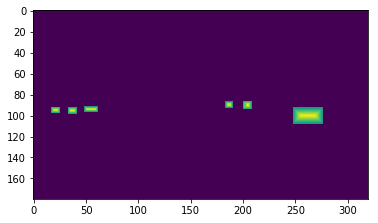

In [12]:
plt.imshow(mask)

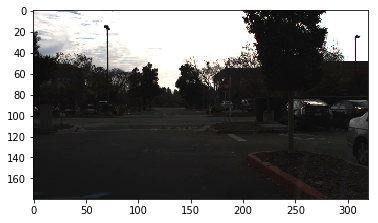

In [13]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_LAB2RGB))

# Let us create the LMDB dataset for fast read-usage.

In [14]:
TRAIN = px.Writer(dirpath='TRAIN', map_size_limit=20000, ram_gb_limit=2)
VAL = px.Writer(dirpath='VAL', map_size_limit=20000, ram_gb_limit=2)

In [15]:
IMAGES = []
MASKS = []
NCAR = []
c = 0
b=0
j=1

max_cars = 0
train = cars_images
for filename in tqdm(cars_images):
    img,mask,n_cars = x_y_from_filename(filename)
    max_cars=np.max([max_cars,n_cars])
    if n_cars == 2:

        IMAGES.append(img)
        MASKS.append(mask)
        NCAR.append(n_cars)

        c+=1
        if c ==32 :
            j = j +1

            IMAGES_BATCH = np.array(IMAGES)
            MASKS_BATCH = np.array(MASKS)
            NCAR_BATCH = np.array(NCAR)
            if j ==11:
                VAL.put_samples('image', IMAGES_BATCH, 'mask', MASKS_BATCH , 'ncar',NCAR_BATCH)
                j=1
            else:
                TRAIN.put_samples('image', IMAGES_BATCH, 'mask', MASKS_BATCH , 'ncar',NCAR_BATCH)

            IMAGES = []
            MASKS = []
            NCAR = []
            c = 0
IMAGES_BATCH = np.array(IMAGES)
MASKS_BATCH = np.array(MASKS)
NCAR_BATCH = np.array(NCAR)
TRAIN.put_samples('image', IMAGES_BATCH, 'mask', MASKS_BATCH , 'ncar',NCAR_BATCH)
TRAIN.close()
VAL.close()

100%|██████████| 20163/20163 [36:31<00:00,  9.57it/s]
